In [1]:
from core.preprocessing import make_small_train, make_small_dev, StatisticalClearSky, DataManager, make_batch
import numpy as np
import pandas as pd
df = pd.read_pickle('data/master_dataset.pkl').fillna(0)
df = df.loc['2015-07-15':'2017-07-14']
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

In [2]:
def plot_trends_and_total(df, start=None, stop=None):
    if start is None:
        start = df.index[0]
    if stop is None:
        stop = df.index[-1]
    cols = df.columns
    fig, axes = plt.subplots(nrows=2, figsize=(12,10), sharex=True)
    df.loc[start:stop].plot(y=cols[:-1], legend=False, linewidth=1, ax=axes[0])
    df.loc[start:stop].plot(y=cols[-1], linewidth=1, ax=axes[1])

mixed = make_small_train(df, 'mixed')
plot_trends_and_total(mixed)

sunny = make_small_train(df, 'sunny')
plot_trends_and_total(sunny)

cloudy = make_small_train(df, 'cloudy')
plot_trends_and_total(cloudy)

comb = make_small_train(df, 'combined')
plot_trends_and_total(comb)

dev = make_small_dev(df)
plot_trends_and_total(dev)

from core.problems import ManyToOneRegression

# Problem parameters
window = 5*12 # window size (to be determined from correlation analysis)
future = 3*12  # prediction window into the future

# Optimization parameters
nepochs = 50
batchsize = 1000

problem = ManyToOneRegression(mixed, window=window, future=future)

feat = problem.featurize(100)

%time np.array([mixed.iloc[i:i+window, :-1].values.ravel() for i in xrange(len(mixed) - problem.window - problem.future)]).shape

mixed.shape

i = 75
mixed.iloc[i:i+window, :-1].values.ravel()

In [3]:
dm = DataManager()
dm.load_all_and_split()

In [4]:
len(dm.original_dev)

2304

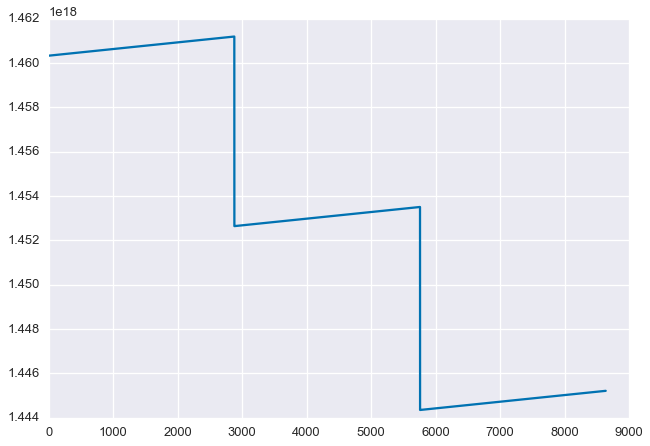

In [13]:
plt.plot(dm.original_train.index)

In [12]:
dm.swap_index()

In [3]:
present = 3*12
future = 3*12

dm = DataManager()
dm.load_all_and_split(kind='all')
dftrain = dm.original_train
dfdev = dm.original_dev

In [5]:
X, Y, D = make_batch(dftrain, 100, present, future)

In [11]:
X.shape

(100, 2628)

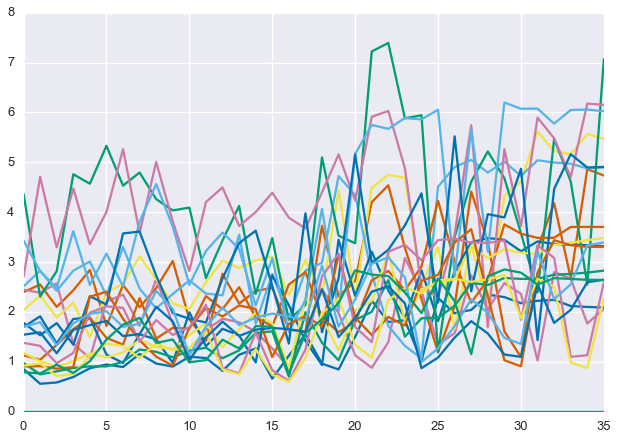

In [32]:
for s in xrange(20):
    plt.plot(X[52,s*present:(s+1)*present])

[[<matplotlib.lines.Line2D at 0x11f9fe7d0>]]

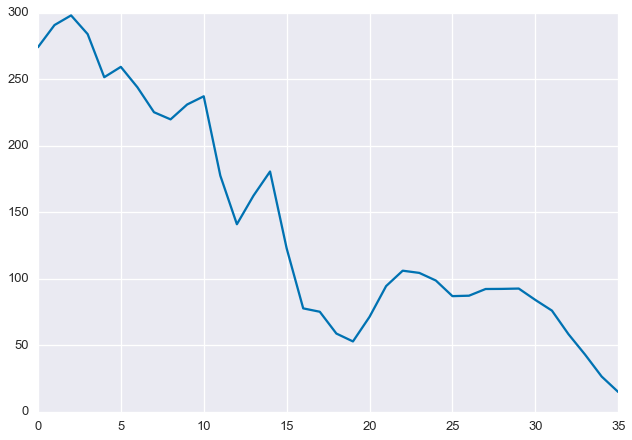

In [33]:
[plt.plot(Y[52])]